In [46]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering, DBSCAN
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import adjusted_mutual_info_score, silhouette_score, davies_bouldin_score, calinski_harabasz_score, normalized_mutual_info_score
import umap.umap_ as umap
from scipy.spatial.distance import pdist

%matplotlib inline

def nmi(y, labels):
    nmi_ = normalized_mutual_info_score(y, labels, average_method='geometric')
    return nmi_

def distance_pair(arr, oth_arr, type='euclidean', p=2):
    k = oth_arr.shape[0]
    n = arr.shape[0]
    diff_matrix = np.zeros((k, n))
    if type=='euclidean':
        for i in range(k):
            diff = (arr - oth_arr[i])
            diff_prod = diff.dot(diff.T)
            diff_matrix[i] = np.sqrt(diff_prod[np.diag_indices(n)])
    if type=='manhattan':
        for i in range(k):
            diff = abs(arr - oth_arr[i])
            diff_matrix[i] = np.sum(diff, axis=1)
    if type=='lp':
        for i in range(k):
            diff = (arr - oth_arr[i])
            diff = diff**p
            diff_prod = diff.sum()
            diff_prod = diff.dot(diff.T)
            diff_matrix[i] = np.sqrt(diff_prod[np.diag_indices(n)])
            
    return diff_matrix.T

def kmeans(X, k, random_state=123):
    np.random.seed(random_state)
    n = X.shape[0]
    centroids = X[np.random.randint(0, n, k), :]
    num_iter = 300
    labels = np.argmin(distance_pair(X, centroids), axis=1)
    for iter in range(num_iter):
        for i in range(k):
            centroids[i] = X[np.where(labels==i)[0],:].mean(axis=0)
        new_labels = np.argmin(distance_pair(X, centroids), axis=1)
        if np.array_equal(labels, new_labels):
            return labels
        labels = new_labels
    return labels

Loading data

In [47]:
df = pd.read_csv('msdata.csv')

In [48]:
df.shape

(694, 5002)

Data cleaning: eliminating errors, missing values, duplicates, noise, outliers

Dataset contains no missing values

In [49]:
df.isnull().sum().sum()

0

Detecting extreme values

In [50]:
df.iloc[:,2:].max().max()

26.3404

In [51]:
df.iloc[:,2:].min().min()

0.0

Checking for duplicate rows 

In [52]:
duplicateRowsDF = df[df.duplicated()]

In [53]:
duplicateRowsDF

,id,class,f1,f2,f3,f4,f5,f6,f7,f8,...,f4991,f4992,f4993,f4994,f4995,f4996,f4997,f4998,f4999,f5000


There are still might be noise and errors

Visualization of data

We use TSNE dimensionality reduction to visualize data

In [54]:
X = df.iloc[:,2:].to_numpy()
y = df['class'].to_numpy()

In [123]:
X_tsne_2d = TSNE(n_components=2, perplexity=100).fit_transform(X)
X_tsne_3d = TSNE(n_components=3).fit_transform(X)

In [86]:
def plot_data_2d(X_2d, y, xlabel, ylabel, title):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.scatter(X_2d[:, 0], X_2d[:, 1], c=y)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
def plot_data_3d(X_3d, y, xlabel, ylabel, zlabel, title):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1, projection='3d')
    ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2], c=y)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_ylabel(zlabel)
    ax.set_title(title)

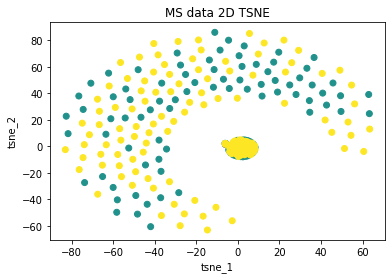

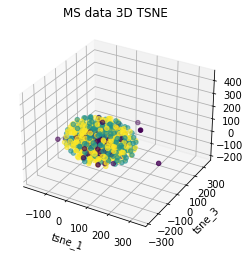

In [124]:
plot_data_2d(X_tsne_2d, y, 'tsne_1', 'tsne_2', 'MS data 2D TSNE')
plot_data_3d(X_tsne_3d, y, 'tsne_1', 'tsne_2', 'tsne_3', 'MS data 3D TSNE')

In [60]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [63]:
ks = range(2,10)

In [134]:

silh_sklearn = []
ch_sklearn = []
db_sklearn = []
nmi_sklearn = []
nmi_custom = []

silh_sklearn_spectral = []
ch_sklearn_spectral = []
db_sklearn_spectral = []
nmi_sklearn_spectral = []
nmi_custom_spectral = []

silh_sklearn_agglo = []
ch_sklearn_agglo = []
db_sklearn_agglo = []
nmi_sklearn_agglo = []
nmi_custom_agglo = []

silh_sklearn_db = []
ch_sklearn_db = []
db_sklearn_db = []
nmi_sklearn_db = []
nmi_custom_db = []

for k in ks:
    model = KMeans(n_clusters=k)
    labels = model.fit_predict(X)
    silh_sklearn.append(silhouette_score(X, labels))
    ch_sklearn.append(calinski_harabasz_score(X, labels))
    db_sklearn.append(davies_bouldin_score(X, labels))
    nmi_sklearn.append(adjusted_mutual_info_score(y, labels))
    nmi_custom.append(nmi(y, labels))

for k in ks:
    model = SpectralClustering(n_clusters=k, gamma=1, n_init=100, affinity='poly', degree=15)
    labels = model.fit_predict(X)
    silh_sklearn_spectral.append(silhouette_score(X, labels))
    ch_sklearn_spectral.append(calinski_harabasz_score(X, labels))
    db_sklearn_spectral.append(davies_bouldin_score(X, labels))
    nmi_sklearn_spectral.append(adjusted_mutual_info_score(y, labels))
    nmi_custom_spectral.append(nmi(y, labels))

for k in ks:
    model = AgglomerativeClustering(n_clusters=k, linkage='single', affinity='cosine')
    labels = model.fit_predict(X)
    silh_sklearn_agglo.append(silhouette_score(X, labels))
    ch_sklearn_agglo.append(calinski_harabasz_score(X, labels))
    db_sklearn_agglo.append(davies_bouldin_score(X, labels))
    nmi_sklearn_agglo.append(adjusted_mutual_info_score(y, labels))
    nmi_custom_agglo.append(nmi(y, labels))


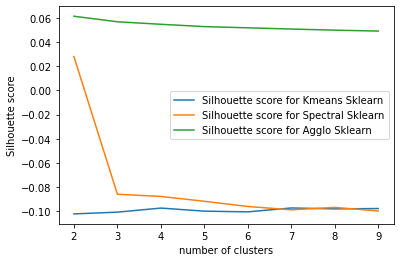

In [161]:
plt.plot(ks, silh_sklearn, label='Silhouette score for Kmeans Sklearn')
plt.plot(ks, silh_sklearn_spectral, label='Silhouette score for Spectral Sklearn')
plt.plot(ks, silh_sklearn_agglo, label='Silhouette score for Agglo Sklearn')
plt.xlabel('number of clusters')
plt.ylabel('Silhouette score')



plt.legend()

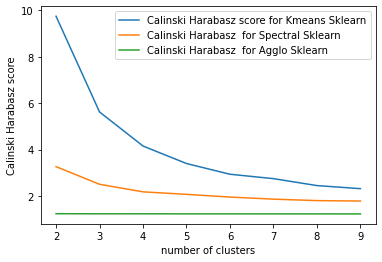

In [162]:
plt.plot(ks, ch_sklearn , label='Calinski Harabasz score for Kmeans Sklearn')
plt.plot(ks, ch_sklearn_spectral, label='Calinski Harabasz  for Spectral Sklearn')
plt.plot(ks, ch_sklearn_agglo, label='Calinski Harabasz  for Agglo Sklearn')
plt.xlabel('number of clusters')
plt.ylabel('Calinski Harabasz score')

plt.legend()

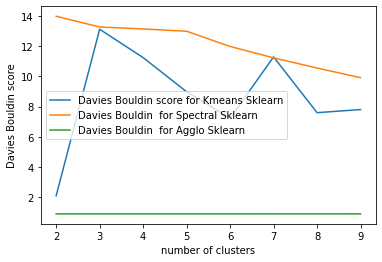

In [165]:
plt.plot(ks, db_sklearn , label='Davies Bouldin score for Kmeans Sklearn')
plt.plot(ks, db_sklearn_spectral, label='Davies Bouldin  for Spectral Sklearn')
plt.plot(ks, db_sklearn_agglo, label='Davies Bouldin  for Agglo Sklearn')

plt.xlabel('number of clusters')
plt.ylabel('Davies Bouldin score')

plt.legend()

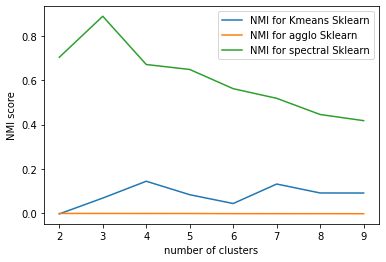

In [166]:
plt.plot(ks, nmi_sklearn , label='NMI for Kmeans Sklearn')
plt.plot(ks, nmi_sklearn_agglo, label='NMI for agglo Sklearn')
plt.plot(ks, nmi_sklearn_spectral, label='NMI for spectral Sklearn')

plt.xlabel('number of clusters')
plt.ylabel('NMI score')

plt.legend()

In [1]:
kmeans_baseline = KMeans(3)

labels = kmeans_baseline.fit_predict(X)

NameError: name 'KMeans' is not defined

In [89]:
def draw_class_cluster_subplots(X_2d, classes, clusters, xlabel, ylabel, title_1, title_2):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
    ax1.scatter(X_2d[:, 0], X_2d[:, 1], c=classes)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    ax1.set_title(title_1)
    ax2.scatter(X_2d[:, 0], X_2d[:, 1], c=clusters)
    ax2.set_xlabel(xlabel)
    ax2.set_ylabel(ylabel)
    ax2.set_title(title_2)

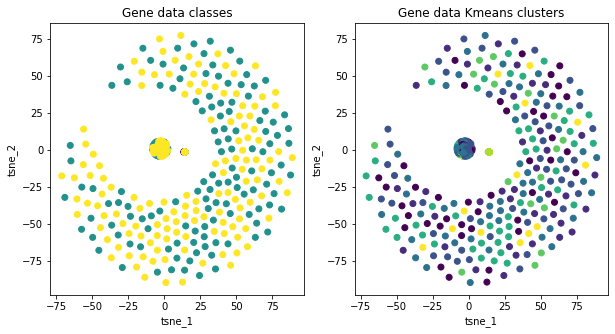

In [90]:
draw_class_cluster_subplots(X_tsne_2d, y, labels, xlabel='tsne_1', ylabel='tsne_2', title_1='Gene data classes', title_2='Gene data Kmeans clusters')

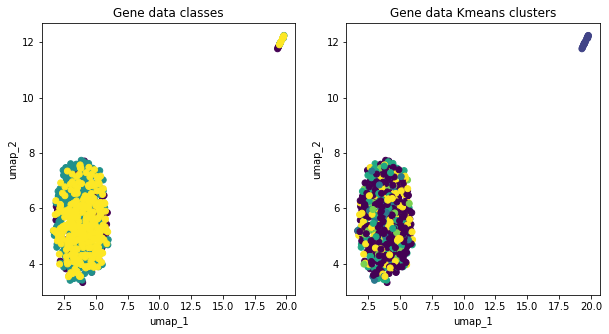

In [32]:
draw_class_cluster_subplots(X_umap_2d, y, labels, xlabel='umap_1', ylabel='umap_2', title_1='Gene data classes', title_2='Gene data Kmeans clusters')

Calculate NMI

In [91]:
nmi(y, labels)

0.4610977468019644

In [34]:
adjusted_mutual_info_score(y, labels, average_method="geometric")

0.15607302623897917

Scaling and normalization

    - min-max scaling $y=\frac{x - min(x)}{max(x) - min(x)}$
    - mean-normalization $y=\frac{x - mean(x)}{max(x)-min(x)}$
    - standardization $y=\frac{x-mean(x)}{stdev(x)}$ 

In [92]:
X_min_max = (X - X.min())/(X.max()-X.min())

In [93]:
labels_min_max = kmeans_baseline.fit_predict(X_min_max)

NameError: name 'kmeans_baseline' is not defined

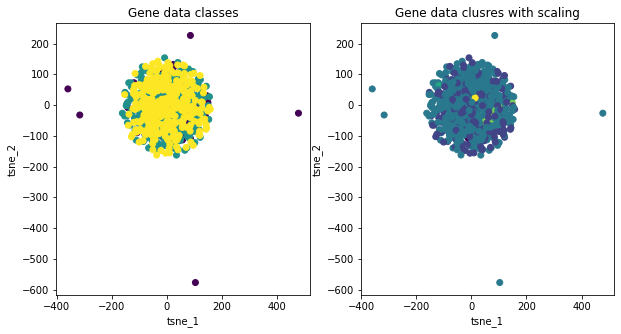

In [37]:
draw_class_cluster_subplots(X_tsne_2d, y, labels_min_max, 'tsne_1', 'tsne_2', 'Gene data classes', 'Gene data clusres with scaling')

In [38]:
nmi(y, labels_min_max)

0.06603406666955991

In [41]:
X_mean_centr = (X - X.mean(axis=0))/(X.max()-X.min())

In [42]:
labels_mean = kmeans_baseline.fit_predict(X_mean_centr)

In [43]:
nmi(y, labels_mean)

0.13714902019894307

In [44]:
adjusted_mutual_info_score(y, labels_mean, average_method="geometric")

0.13140137436306185

In [45]:
X_standard = (X-X.mean(axis=0))/X.std(axis=0)

In [46]:
labels_standard = kmeans_baseline.fit_predict(X_standard)

In [47]:
nmi(y, labels_standard)

0.04605201447951544

Text(0, 0.5, 'cumulative explained variance')

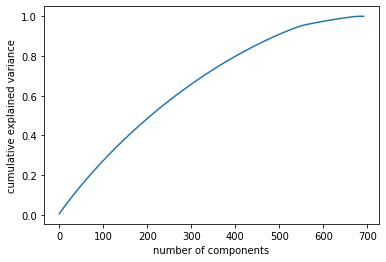

In [261]:
kpca = KernelPCA(kernel='cosine').fit_transform(X)
explained_variance = np.var(kpca, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)

plt.plot(np.cumsum(explained_variance_ratio))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [ ]:
# RESULTS
results_dict = {'method':['Spectral clustering'], 'affinity': 'poly', 'dim_reduction': 'None', 'nmi':[0.89]}

In [262]:
# PCA
for i, kernel in enumerate(('linear', 'rbf', 'cosine', 'sigmoid', 'poly')):
    pca = KernelPCA(n_components=50, kernel=kernel)
    X_red_pca = pca.fit_transform(X)
    spect = SpectralClustering(n_clusters=3, gamma=1, n_init=100, affinity='poly', degree=10)
    labels_spect = spect.fit_predict(X_red_pca)

    results_dict['distance'].append('poly')
    results_dict['nmi'].append(nmi(y, labels_spect))
    results_dict['filtering'].append(None)
    results_dict['dim_reduction'].append('PCA (components=50, kernel={})'.format(kernel))
    print(kernel, nmi(y, labels_spect))

for i in range(10, 200, 10):
    pca = KernelPCA(n_components=i, kernel='cosine')
    X_red_pca = pca.fit_transform(X)
    spect = SpectralClustering(n_clusters=3, gamma=1, n_init=100, affinity='poly', degree=10)
    labels_spect = spect.fit_predict(X_red_pca)
    
    results_dict['distance'].append('poly')
    results_dict['nmi'].append(nmi(y, labels_spect))
    results_dict['filtering'].append(None)
    results_dict['dim_reduction'].append('PCA (components={}, kernel=cosine)'.format(i))
    print(i, nmi(y, labels_spect))

for i, kernel in enumerate(('nearest_neighbors', 'rbf', 'poly', 'polynomial', 'laplacian', 'sigmoid')):
    pca = KernelPCA(n_components=140, kernel='cosine')
    X_red_pca = pca.fit_transform(X)
    spect = SpectralClustering(n_clusters=3, gamma=1, n_init=100, affinity=kernel)
    labels_spect = spect.fit_predict(X_red_pca)
    print(kernel, nmi(y, labels_spect))



KeyError: 'distance'

In [ ]:
pca = KernelPCA(n_components=50, kernel='cosine')
X_red_pca = pca.fit_transform(X)
spect = SpectralClustering(n_clusters=3, gamma=1, n_init=100, affinity='poly', degree=10)
labels_spect = spect.fit_predict(X_red_pca)
print(kernel, nmi(y, labels_spect))

In [213]:
# TSNE
reducer_tsne = TSNE(n_components=2, perplexity=30) 
X_red_tsne = reducer_tsne.fit_transform(X)
spect = SpectralClustering(n_clusters=3, gamma=1, n_init=100, affinity='poly', degree=10)
labels_spect = spect.fit_predict(X_red_tsne)
print(i, nmi(y, labels_spect))

# UMAP
for i in range(1, 100, 10):
    reducer_umap = umap.UMAP(
        n_neighbors=i,
        min_dist=0.0,
        # n_components=i,
        random_state=42) 
    X_red_umap = reducer_umap.fit_transform(X)


# spect = SpectralClustering(n_clusters=3, gamma=1, n_init=100, affinity='poly', degree=10)

Error: Pip module debugpy is required for debugging cells. You will need to install it to debug cells.

In [257]:
# PCA
pca = KernelPCA(n_components=140, kernel='cosine')
X_red_pca = pca.fit_transform(X)
    
# TSNE
reducer_tsne = TSNE(n_components=2, perplexity=30) 
X_red_tsne = reducer_tsne.fit_transform(X_red_pca)

# UMAP
reducer_umap = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=10,
    random_state=42) 
X_red_umap = reducer_umap.fit_transform(X_red_pca)

for i, linkage in enumerate(('ward', 'single', 'complete', 'average')):
    agglo = AgglomerativeClustering(n_clusters=3, linkage=linkage)
    labels_agglo = agglo.fit_predict(X)
    labels_agglo_pca = agglo.fit_predict(X_red_pca)
    labels_agglo_tsne = agglo.fit_predict(X_red_tsne)
    labels_agglo_umap = agglo.fit_predict(X_red_umap)
    print(linkage, nmi(y, labels_agglo))




ward 0.2840866472160896
single 0.018971829084704715
complete 0.19109328400372913
average 0.018971829084704715


In [ ]:

df.style.set_caption("Spectral clustering")
pd.DataFrame(results_dict)


In [263]:
# Agglomerative
results_dict = {'method':['Agglomerative clustering'], 'affinity': 'poly', 'nmi':[0.89]}
results_dict['method'].append('kmeans')
results_dict['distance'].append('euclidean')
results_dict['nmi'].append(0.98)
results_dict['filtering'].append(None)
results_dict['dim_reduction'].append('UMAP')
results_dict['n_components'].append(700)

df.style.set_caption("Agglomerative clustering")
pd.DataFrame(results_dict)


KeyError: 'distance'

In [72]:
reducer = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42) 
X_red_umap = reducer.fit_transform(X)
kmeans = KMeans(n_clusters=3)
# db = DBSCAN(eps=0.1, min_samples=30).fit_predict(X)
labels_umap = kmeans.fit_predict(X_red_umap)
display(nmi(y, labels_umap))
display(adjusted_mutual_info_score(y, labels_umap, average_method="geometric"))

0.00044710239108737814

-0.002759187394462854

Distances to overcome curse of dimensionality
    - LP with small p
    - Cosine similarity
    - match based similarity
    
Mahalanobis distance to take distribution into account
Isomap 

KMeans Cosine similarity

Text(0, 0.5, 'frequency')

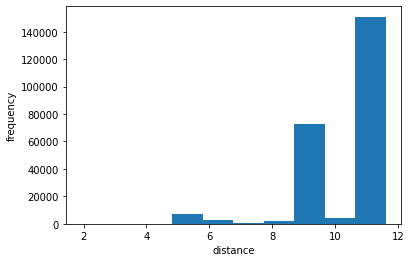

In [461]:
plt.hist(pairwise_dist)
plt.xlabel('distance')
plt.ylabel('frequency')

Study entropy

In [218]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [254]:
X_train, X_test, y_train, y_test = train_test_split(X_min_max, y, test_size=0.1)

In [255]:
df['class'].value_counts(normalize=True)

3    0.446686
2    0.373199
1    0.180115
Name: class, dtype: float64

In [228]:
lr = LogisticRegression(multi_class='multinomial')

In [256]:
scores = []
for i in range(5000):
    lr.fit(X_train[:,i].reshape((-1, 1)), y_train)
    scores.append(f1_score(y_test, lr.predict(X_test[:,i].reshape((-1,1))), average='macro'))

0.4615384615384616

0.16117216117216115

(694, 1538)
0.7506632174155985


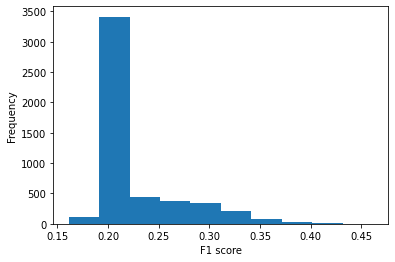

In [253]:
display(np.max(scores))
display(np.min(scores))
plt.hist(scores)
plt.xlabel('F1 score')
plt.ylabel('Frequency')

X_model_select = X[:,np.argwhere((np.array(scores)<0.19) | (np.array(scores)>0.22)).flatten()]
print(X_model_select.shape)
pca = KernelPCA(n_components=50, kernel='cosine')
X_red_pca = pca.fit_transform(X)
spect = SpectralClustering(n_clusters=3, gamma=1, n_init=100, affinity='poly', degree=10)
labels_spect = spect.fit_predict(X_model_select)
print(nmi(y, labels_spect))

In [234]:
np.argsort(scores)[:10]

array([3863,  362, 1819,  765, 1157,  642,   50, 1076, 1127,  514])

DBSCAN

In [62]:
db = DBSCAN(eps=4, min_samples=10).fit(X_min_max)

In [65]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, labels))
print("Completeness: %0.3f" % metrics.completeness_score(y, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(y, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(y, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_min_max, labels))

Estimated number of clusters: 1
Estimated number of noise points: 671
Homogeneity: 0.000
Completeness: 0.000
V-measure: 0.000
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.003
Silhouette Coefficient: -0.103
